# NEURAL NETWORKS AND DEEP LEARNING

---
Scaramuzza Luca 2019132 - Homework 2
---


# Set up the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
import os 
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
torch.manual_seed(0)

# Import Dataset

In [4]:
to_tensor = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST('dataset', train=True, download=True, transform=to_tensor)
test_dataset  = torchvision.datasets.FashionMNIST('dataset', train=False, download=True, transform=to_tensor)

In [5]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

dataiter = iter(train_dataset_loader)
X_train, y_train = dataiter.next()
dataiter = iter(test_dataset_loader)
X_test, y_test = dataiter.next()

In [6]:
batch_data, batch_labels = next(iter(train_dataset_loader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataset_loader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([64, 1, 28, 28])
	 Labels: torch.Size([64])
TEST BATCH SHAPE
	 Data: torch.Size([64, 1, 28, 28])
	 Labels: torch.Size([64])


# Encoder Decoder model

Encoder model definition

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim=2, conv1=8, conv2=16, conv3=32, lin=64, drop=0.5):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=conv1, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=drop),
            nn.Conv2d(in_channels=conv1, out_channels=conv2, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=drop),
            nn.Conv2d(in_channels=conv2, out_channels=conv3, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=drop)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=conv3*3*3, out_features=lin),
            nn.ReLU(True),
            nn.Dropout(p=drop),
            nn.Linear(in_features=lin, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

Decoder model definition

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1=8, conv2=16, conv3=32, lin=64, drop=0.5):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=lin),
            nn.ReLU(True),
            nn.Dropout(p=drop),
            nn.Linear(in_features=lin, out_features=conv3*3*3),
            nn.ReLU(True),
            nn.Dropout(p=drop)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=conv3, out_channels=conv2, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=drop),
            nn.ConvTranspose2d(in_channels=conv2, out_channels=conv1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=drop),
            nn.ConvTranspose2d(in_channels=conv1, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [9]:
encoded_space_dim = 64
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [10]:
loss_fn = torch.nn.MSELoss()
lr = 1e-3
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0.5, inplace=False)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [11]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.data

In [12]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [13]:
def training_cycle(num_epochs, encoder, decoder, device, train_dataloader, loss_fn, optim, test_dataset, verbose):
    train_loss_log = []
    val_loss_log = []
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        
        ### TRAIN
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_log.append(train_loss)
        print('\n\n\t TRAIN - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, train_loss))

        ### VALIDATION
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataset_loader, 
            loss_fn=loss_fn)
        val_loss_log.append(val_loss)
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        if(verbose):
            fig, axs = plt.subplots(1, 2, figsize=(12,6))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')
    return (train_loss_log,val_loss_log)


In [15]:
num_epochs=30
conv1=16
conv2=32
conv3=64
lin=64
encoded_space_dim = 64
lr=0.001
wd=0.0001
drop=0

encoder = Encoder(encoded_space_dim = encoded_space_dim, conv1=conv1, conv2=conv2, conv3=conv3, lin=lin)
decoder = Decoder(encoded_space_dim = encoded_space_dim, conv1=conv1, conv2=conv2, conv3=conv3, lin=lin)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=wd)

encoder.to(device)
decoder.to(device)

train_loss_log,val_loss_log = training_cycle(num_epochs, encoder, decoder, device, train_dataset_loader, loss_fn, optim, test_dataset,verbose=False)

EPOCH 1/30


	 TRAIN - EPOCH 1/30 - loss: 0.053383




	 VALIDATION - EPOCH 1/30 - loss: 0.047917


EPOCH 2/30


	 TRAIN - EPOCH 2/30 - loss: 0.049516




	 VALIDATION - EPOCH 2/30 - loss: 0.041678


EPOCH 3/30


	 TRAIN - EPOCH 3/30 - loss: 0.050028




	 VALIDATION - EPOCH 3/30 - loss: 0.039939


EPOCH 4/30


	 TRAIN - EPOCH 4/30 - loss: 0.052690




	 VALIDATION - EPOCH 4/30 - loss: 0.039227


EPOCH 5/30


	 TRAIN - EPOCH 5/30 - loss: 0.050007




	 VALIDATION - EPOCH 5/30 - loss: 0.038104


EPOCH 6/30


	 TRAIN - EPOCH 6/30 - loss: 0.049925




	 VALIDATION - EPOCH 6/30 - loss: 0.037322


EPOCH 7/30


	 TRAIN - EPOCH 7/30 - loss: 0.045411




	 VALIDATION - EPOCH 7/30 - loss: 0.037451


EPOCH 8/30


	 TRAIN - EPOCH 8/30 - loss: 0.044291




	 VALIDATION - EPOCH 8/30 - loss: 0.036159


EPOCH 9/30


	 TRAIN - EPOCH 9/30 - loss: 0.046905




	 VALIDATION - EPOCH 9/30 - loss: 0.035760


EPOCH 10/30


	 TRAIN - EPOCH 10/30 - loss: 0.045071




	 VALIDATION - EPOCH 10/30 - loss: 0.035725

## Plot losses and accuracy

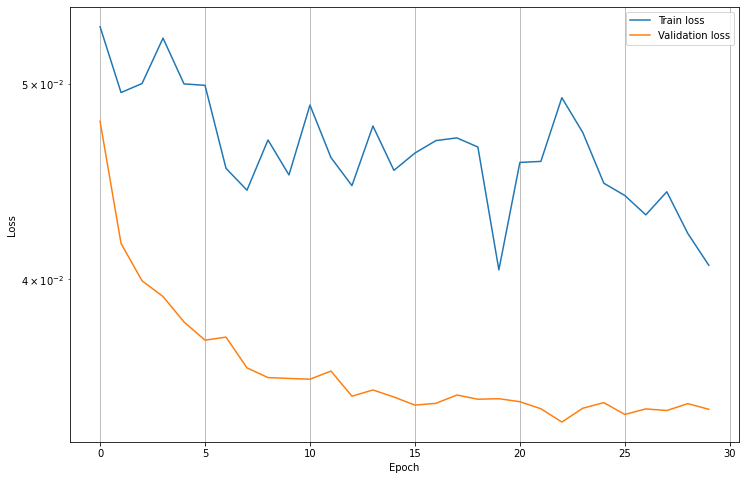

In [16]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Grid search

In [ ]:
encoded_space_dim = [64]
num_epochs=15
Conv1=[8,16]
Conv2=[16,32]
Conv3=[32,64]
FC=[64,128]
LR=[1e-2,1e-3]
L2=[0.0001]
drop=[0,0.5]

hyperparams = [encoded_space_dim,Conv1,Conv2,Conv3,FC,LR,L2,drop]  

iterations=[]
import itertools
for hyper in itertools.product(*hyperparams):
    iterations.append(hyper)
print("Total Combinations:",len(iterations))


best_hyper=None
best_loss=None
for i,hyper in enumerate(iterations):
    print("\n\nIteration:",i,hyper)
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2,dropout=hyper
    encoder = Encoder(encoded_space_dim=encoded_space_dim,drop=dropout, conv1=conv1,conv2=conv2,conv3=conv3,lin=fc)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,drop=dropout, conv1=conv1,conv2=conv2,conv3=conv3,lin=fc)
    loss_fn = torch.nn.MSELoss()
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)
    encoder.to(device)
    decoder.to(device)
    train_loss_log,val_loss_log = training_cycle(num_epochs, encoder, decoder, device, train_dataset_loader, loss_fn, optim, test_dataset,verbose=False)
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper        
print("\n\nBest Model:",best_hyper)

In [17]:
#encoded_space_dim,Conv1,Conv2,Conv3,FC,LR,L2,drop = best_hyper
encoded_space_dim,Conv1,Conv2,Conv3,FC,LR,L2,drop = [64,16,32,64,64,1e-3,0.0001,0]

encoder = Encoder(encoded_space_dim = encoded_space_dim, drop=drop, conv1=Conv1, conv2=Conv2, conv3=Conv3, lin=FC)
decoder = Decoder(encoded_space_dim = encoded_space_dim, drop=drop, conv1=Conv1, conv2=Conv2, conv3=Conv3, lin=FC)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=wd)

encoder.to(device)
decoder.to(device)

train_loss_log,val_loss_log = training_cycle(num_epochs, encoder, decoder, device, train_dataset_loader, loss_fn, optim, test_dataset,verbose=False)

EPOCH 1/30


	 TRAIN - EPOCH 1/30 - loss: 0.025850




	 VALIDATION - EPOCH 1/30 - loss: 0.027343


EPOCH 2/30


	 TRAIN - EPOCH 2/30 - loss: 0.023369




	 VALIDATION - EPOCH 2/30 - loss: 0.023864


EPOCH 3/30


	 TRAIN - EPOCH 3/30 - loss: 0.022885




	 VALIDATION - EPOCH 3/30 - loss: 0.023085


EPOCH 4/30


	 TRAIN - EPOCH 4/30 - loss: 0.021089




	 VALIDATION - EPOCH 4/30 - loss: 0.021857


EPOCH 5/30


	 TRAIN - EPOCH 5/30 - loss: 0.020056




	 VALIDATION - EPOCH 5/30 - loss: 0.021083


EPOCH 6/30


	 TRAIN - EPOCH 6/30 - loss: 0.019423




	 VALIDATION - EPOCH 6/30 - loss: 0.020584


EPOCH 7/30


	 TRAIN - EPOCH 7/30 - loss: 0.018654




	 VALIDATION - EPOCH 7/30 - loss: 0.019812


EPOCH 8/30


	 TRAIN - EPOCH 8/30 - loss: 0.017817




	 VALIDATION - EPOCH 8/30 - loss: 0.019332


EPOCH 9/30


	 TRAIN - EPOCH 9/30 - loss: 0.017434




	 VALIDATION - EPOCH 9/30 - loss: 0.019063


EPOCH 10/30


	 TRAIN - EPOCH 10/30 - loss: 0.017302




	 VALIDATION - EPOCH 10/30 - loss: 0.018682

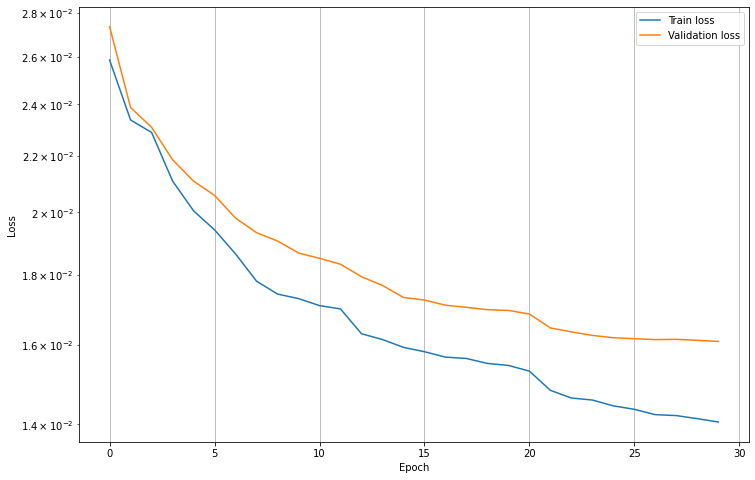

In [58]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Supervised task

In [22]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [23]:
tr_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.8*len(train_dataset)),int(0.2*len(train_dataset))])

print('Samples in training set:',len(tr_dataset))
print('Samples in validation set:',len(val_dataset))

Samples in training set: 48000
Samples in validation set: 12000


In [24]:
tr_dataset.transform = train_transform
val_dataset.transform = train_transform

train_dataloader_sup = DataLoader(tr_dataset, batch_size=256, shuffle=True)
val_dataloader_sup = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [25]:
class_layer = nn.Linear(encoded_space_dim,10)
class_layer.to(device)

loss_sup = nn.CrossEntropyLoss()

params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': class_layer.parameters()}
    ]

optimizer_sup = torch.optim.Adam(params_to_optimize, lr=1e-3)

In [26]:
num_epochs = 20
accuracy_train = 0
accuracy_val = 0
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_pred = []
    train_loss= []
    encoder.train()
    class_layer.train()
    for sample_batched in train_dataloader_sup:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        x = encoder(x_batch)
        out = class_layer(x)
        loss = loss_sup(out, label_batch)
        encoder.zero_grad()
        class_layer.zero_grad()
        loss.backward()
        optimizer_sup.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(label_batch.cpu()))
        train_pred.append(right)
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    val_pred = []
    encoder.eval()
    class_layer.eval()
    with torch.no_grad():
        for sample_batched in val_dataloader_sup:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            x = encoder(x_batch)
            out = class_layer(x)
            loss = loss_sup(out, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
            pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
            right = np.sum(pred == np.array(label_batch.cpu()))
            val_pred.append(right)
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)
    accuracy_train = np.sum(train_pred)/len(tr_dataset)
    accuracy_val = np.sum(val_pred)/len(val_dataset)
    print("Average train loss:[", train_loss, "] ","\nAccuracy train:[", np.round(accuracy_train,5),"] " ,"\nAverage validation loss: [", val_loss, "]", "\nAccuracy validation:[",  np.round(accuracy_val,5),"]")

#################
# EPOCH 0
#################
Average train loss:[ 0.9746708 ]  
Accuracy train:[ 0.67806 ]  
Average validation loss: [ 0.63596874 ] 
Accuracy validation:[ 0.75492 ]
#################
# EPOCH 1
#################
Average train loss:[ 0.57240313 ]  
Accuracy train:[ 0.78929 ]  
Average validation loss: [ 0.52907497 ] 
Accuracy validation:[ 0.80967 ]
#################
# EPOCH 2
#################
Average train loss:[ 0.5148208 ]  
Accuracy train:[ 0.81394 ]  
Average validation loss: [ 0.49133092 ] 
Accuracy validation:[ 0.82708 ]
#################
# EPOCH 3
#################
Average train loss:[ 0.4733153 ]  
Accuracy train:[ 0.83008 ]  
Average validation loss: [ 0.46991646 ] 
Accuracy validation:[ 0.83583 ]
#################
# EPOCH 4
#################
Average train loss:[ 0.45441148 ]  
Accuracy train:[ 0.83742 ]  
Average validation loss: [ 0.4573291 ] 
Accuracy validation:[ 0.84025 ]
#################
# EPOCH 5
#################
Average train loss:[ 0.4347916 ]  
Acc

# Variational autoencoder

In [51]:
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [52]:
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
vae.to(device)
print(vae)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


In [53]:
optimizer = torch.optim.Adam(vae.parameters())
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [54]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataset_loader):
        data = data[0].to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataset_loader.dataset),
                100. * batch_idx / len(train_dataset_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataset_loader.dataset)))

In [55]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_dataset_loader:
            data = data[0].to(device)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_dataset_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [56]:
for epoch in range(0, 50):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 543.641235
Train Epoch: 0 [100/60000 (11%)]	Loss: 328.201141
Train Epoch: 0 [200/60000 (21%)]	Loss: 249.628464
Train Epoch: 0 [300/60000 (32%)]	Loss: 389.514557
Train Epoch: 0 [400/60000 (43%)]	Loss: 467.179718
Train Epoch: 0 [500/60000 (53%)]	Loss: 276.033936
Train Epoch: 0 [600/60000 (64%)]	Loss: 295.424438
Train Epoch: 0 [700/60000 (75%)]	Loss: 258.370758
Train Epoch: 0 [800/60000 (85%)]	Loss: 348.190002
Train Epoch: 0 [900/60000 (96%)]	Loss: 330.170349
====> Epoch: 0 Average loss: 5.3392
====> Test set loss: 4.6197
Train Epoch: 1 [0/60000 (0%)]	Loss: 313.951874
Train Epoch: 1 [100/60000 (11%)]	Loss: 276.778870
Train Epoch: 1 [200/60000 (21%)]	Loss: 123.294876
Train Epoch: 1 [300/60000 (32%)]	Loss: 392.627747
Train Epoch: 1 [400/60000 (43%)]	Loss: 494.816315
Train Epoch: 1 [500/60000 (53%)]	Loss: 194.722061
Train Epoch: 1 [600/60000 (64%)]	Loss: 285.318359
Train Epoch: 1 [700/60000 (75%)]	Loss: 237.899094
Train Epoch: 1 [800/60000 (85%)]	Loss: 315

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


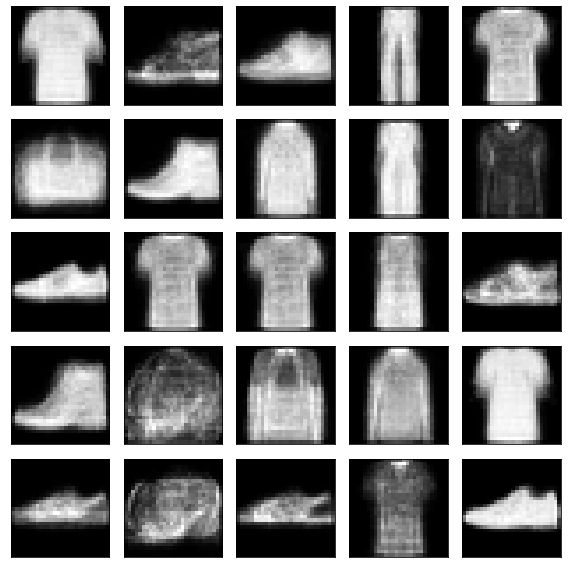

In [57]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    with torch.no_grad():
        z = torch.randn(1, 2).to(device)
        sample = vae.decoder(z).to(device)
    sample=sample.view(1, 1, 28, 28)[0].cpu().squeeze().numpy()
    
    ax.imshow(sample, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Latent space

In [24]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:08<00:00, 1238.88it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,Enc. Variable 10,Enc. Variable 11,Enc. Variable 12,Enc. Variable 13,Enc. Variable 14,Enc. Variable 15,Enc. Variable 16,Enc. Variable 17,Enc. Variable 18,Enc. Variable 19,Enc. Variable 20,Enc. Variable 21,Enc. Variable 22,Enc. Variable 23,Enc. Variable 24,Enc. Variable 25,Enc. Variable 26,Enc. Variable 27,Enc. Variable 28,Enc. Variable 29,Enc. Variable 30,Enc. Variable 31,Enc. Variable 32,Enc. Variable 33,Enc. Variable 34,Enc. Variable 35,Enc. Variable 36,Enc. Variable 37,Enc. Variable 38,Enc. Variable 39,Enc. Variable 40,Enc. Variable 41,Enc. Variable 42,Enc. Variable 43,Enc. Variable 44,Enc. Variable 45,Enc. Variable 46,Enc. Variable 47,Enc. Variable 48,Enc. Variable 49,Enc. Variable 50,Enc. Variable 51,Enc. Variable 52,Enc. Variable 53,Enc. Variable 54,Enc. Variable 55,Enc. Variable 56,Enc. Variable 57,Enc. Variable 58,Enc. Variable 59,Enc. Variable 60,Enc. Variable 61,Enc. Variable 62,Enc. Variable 63,label
0,22.494038,-6.834510,-6.176661,-10.267224,5.623584,2.460068,-11.761850,-13.748280,3.991623,-0.666907,-16.653822,-1.094408,32.692898,0.265625,4.469462,4.983212,-0.108275,-3.283911,-8.395860,-11.087026,-10.747938,-5.052150,-3.397120,-1.322362,-5.683528,-3.435014,25.654636,2.351268,-5.114009,-0.045696,-6.477852,-8.468659,-8.972489,2.178262,2.854193,13.808125,6.329989,2.955326,-2.662860,7.992689,6.492940,10.953332,2.523265,6.753560,-7.636721,-1.812321,-1.791013,2.239452,-8.470201,3.399403,19.563108,-0.709501,26.615057,-8.343338,2.440920,-7.610145,3.055629,10.003692,-3.329273,-2.007872,0.143126,-0.476756,-16.880856,0.787222,9
1,-27.386559,-6.544201,-3.812619,-3.615322,7.915566,-0.185593,-27.422646,-22.098907,-3.753025,-1.858719,-23.673195,1.677829,41.778717,1.083944,-0.912521,3.322880,-1.580822,2.721803,53.302227,-3.049896,-9.182063,-13.214187,8.949891,-2.595256,-1.038996,-0.771776,-8.337637,6.552379,34.349705,-0.018280,-7.389429,-14.988786,12.320279,7.555748,2.510077,-0.155985,1.716883,0.045069,25.836153,15.769943,-29.250336,9.803494,-3.655170,3.825949,-40.133854,-2.631184,1.193187,-2.274483,-1.899769,-1.894041,-25.398060,2.290201,55.618294,0.379860,-1.931696,-1.688272,-3.236145,1.852295,2.968257,-2.031657,-14.839767,3.470859,-1.837394,-0.705652,2
2,-9.704291,15.649718,5.431245,16.563091,-8.886045,7.132683,-18.121391,-19.429029,1.749886,-1.593655,15.171701,3.052360,27.460285,-0.590942,-0.792883,-6.771736,1.398473,-5.575357,13.588326,7.507826,-0.494538,14.579520,6.712139,-0.590041,1.855028,2.301045,19.341932,-3.986009,21.161982,-0.032193,9.555811,0.589538,-1.924484,-4.631119,-3.763429,-10.631128,-13.268240,10.078397,-10.055983,-16.836006,-5.768617,-4.883439,-4.634232,-9.488238,-32.022526,4.467935,2.688785,-6.480211,5.255477,-0.639417,-10.316325,-0.475753,40.561676,1.312643,-6.210746,6.447025,2.272648,-19.467457,1.955423,6.135592,0.570395,-5.805727,12.258699,-1.853316,1
3,-4.859519,12.342364,3.984542,10.980762,-6.980612,0.753762,-13.580539,-14.329576,2.630299,-0.116786,18.873985,0.441568,19.532314,-1.233401,-5.610094,-7.420571,0.211084,-2.995515,-3.826136,6.716698,1.708014,11.782733,5.173665,2.594698,0.720689,-0.881003,12.763391,-2.229902,17.588369,-0.020680,9.317875,2.233155,-4.432467,-4.175199,-4.839350,-9.659774,-7.342999,4.640166,-10.993868,-16.895729,2.068082,-4.968845,-0.299783,-13.025952,-22.130198,3.555024,1.373433,-2.095288,6.373779,0.464994,-2.636200,-1.708010,31.569204,3.222914,-0.830913,9.458965,-0.268090,-13.101104,1.657135,1.229476,2.071925,-4.546455,10.737237,1.051155,1
4,-13.615882,-7.546832,0.669106,-9.686471,2.384857,-10.170651,-19.291836,-15.596069,-3.832311,-2.245285,-8.490676,-0.182922,28.281998,-1.314343,-5.432951,-0.764828,-2.684666,10.514331,18.278326,2.991026,-5.233489,-5.677621,-0.322608,2.736811,0.805096,-1.902769,-4.360937,0.427192,25.233921,-0.013355,-0.016527,-4.852252,5.023728,0.921326,0.695649,-3.055832,5.707787,-9.246173,7.626037,10.06

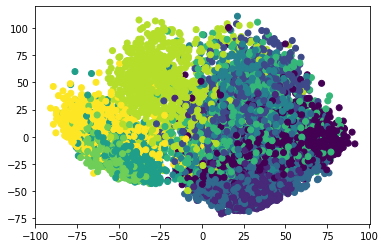

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


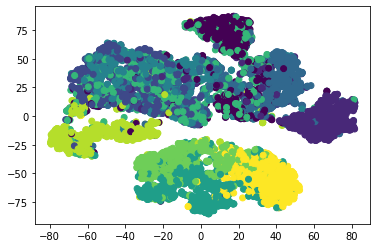

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

# Sample generation

[-3.612591714753016, -15.625081036119013, 1.9743170533206964, 10.467139118757174, 20.54698055987268, -7.016260955073399, -19.795802719176237, -12.5923204685988, 5.420415236353847, -10.436098221106604, 11.970446273381555, -12.457260011671778, 15.905186609706853, -3.371031849435285, -13.909158340655381, 15.094574466676047, 12.566015155582708, 0.03717947838443081, 27.475295648151615, 3.805355799974123, -2.4032381774440914, -48.45400674358002, 20.06959668331414, -12.007403162277932, 2.0372381208681745, 3.073498562247522, 39.88218801706526, 7.624425805545339, 27.439058715496962, 0.08678096832718346, 9.065468477424922, 4.685680262365885, -10.83793790914213, -8.799644649132407, -17.067991793533306, 23.27799443844374, 14.854833911171447, -20.55410557162773, 45.094089764165446, -16.4853951724402, -14.060507079887923, 17.14245503604694, 4.755617164912536, -3.474472012097939, -31.276403897272143, -8.61532296840733, -2.438888687853014, -2.5381728789586866, 12.902407507743057, -9.066518062950163, 1

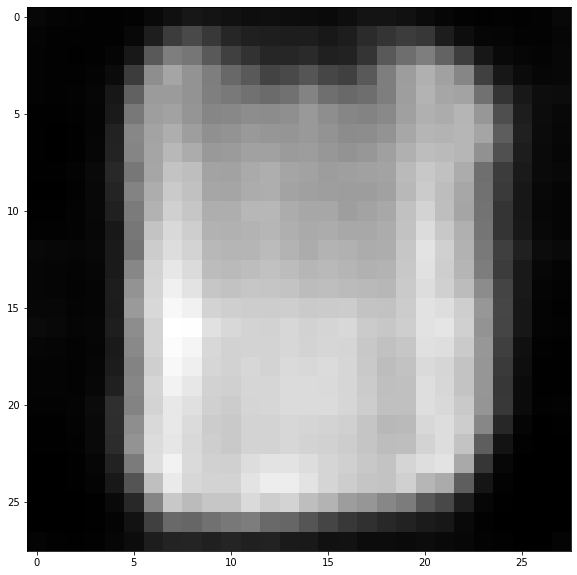

[-29.534767713689657, 14.552788665815562, -5.826242430301079, -21.341973570421878, -12.307195473101038, 9.176501705888207, -8.826915832322772, -11.834003168934291, -9.080622947134207, 1.4572751474224734, -47.11468534399493, -6.675802654985366, 14.78866066387392, 6.643283157378182, -28.14838151822714, -6.943724602292518, 1.8721536641651415, -0.4446117483427514, -30.06535211439373, 3.7914407819432228, -12.895908180423799, -33.863734123425914, -2.814448128854604, -10.231664621043176, 4.965015230270037, -11.216566247333798, -15.61661725517083, -8.321054217806669, 29.142798195736837, -0.1028863396494652, 9.198090463764522, -17.996952381582318, 13.62816145779762, 15.546594228421338, -7.8919537837683595, 9.887617119022998, 11.126677085352505, -22.59839008292196, 40.27738249439882, -3.0586027323739664, -12.251544654407205, -5.888197400729504, 7.5401084643589655, 17.602130820360088, -0.8577874460426855, 9.595185344792721, 13.854075572359765, 18.307634216117876, -8.760806604539951, -5.1364560162

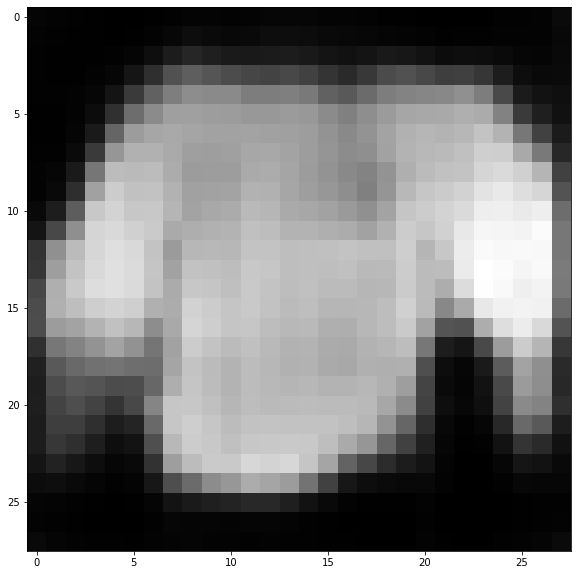

[9.622264565788711, -40.013104913950926, -30.306092582443135, -2.835544392681861, 26.623436115906387, 0.04732179564945582, -30.05187412410803, -27.643741629767007, 1.9114439400295922, -5.570848948883885, -44.03329927562869, -7.676890545127408, 54.72904368579212, 2.6222397380762406, -10.995456077584407, 3.0981967978457092, 4.033225295790503, 23.594165721184453, -5.113549038284837, 2.0097096782918697, -14.842203055223226, 3.7241697375202136, 20.777448678233178, -16.378876620209358, 10.359138667709828, -5.568959127627789, 33.27258815030714, 16.662996343358607, 18.13308279811511, 0.19934098498495312, -24.81333650100671, -24.568344095704134, -7.272710649303603, 21.951674387606317, 5.176816773943795, -31.099550779444694, 23.137343824748086, 18.94074916160755, 7.287542087221873, -9.69734281847846, 14.54191158486492, 24.642548364477, -11.16621832244982, -9.668673843355235, -31.876192810677427, -3.047418899810319, 3.934907484041876, 5.159738305882627, -9.093409378645578, -8.111591693193315, 23.

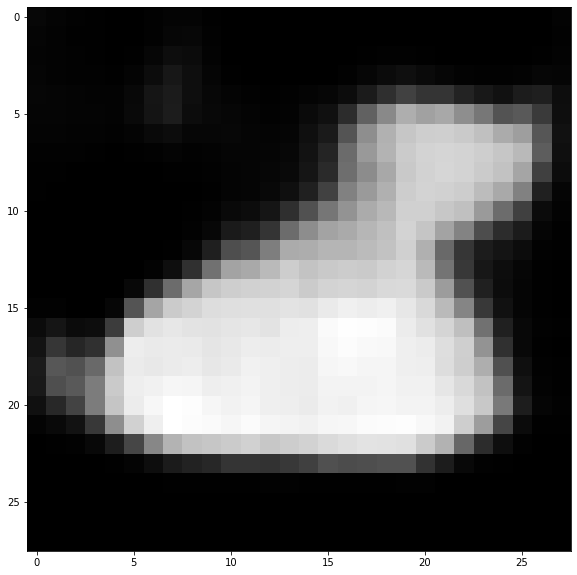

[-18.6667837619351, -8.410169432726, 14.270183635139531, 0.40926346109944944, -16.6580435564964, -24.205859746833152, -23.11466815181963, -30.43339498481044, 9.29644541699566, -7.1730076983747875, -19.139689569077582, -12.86595915168155, 40.25880209543398, 2.781260504550735, 9.15807769002597, 6.160069678893434, -4.375586120110449, 17.453661640095966, 22.641671175394364, -14.557213081212147, -3.812836525617783, -24.67418991195419, 12.230934013882276, 4.097333448614371, -9.47152852108632, -7.386742745900337, -38.95687946670072, 29.945520932210755, 30.849051108922907, -0.10474486574841081, -26.073396145444633, -21.134180242395903, 14.47836902721804, -11.8594148001275, 2.594113710778057, 22.608625674112737, 20.29739935314813, -27.889139126980492, 43.61909949545925, -3.5044247145906233, -33.70764431044637, -2.3979237338252712, 21.038111829075348, -9.07464628515797, -27.84026597938487, -6.833856387314981, 12.093989692770968, -9.474986051787095, -4.901414516091414, -2.4678768327571206, -32.13

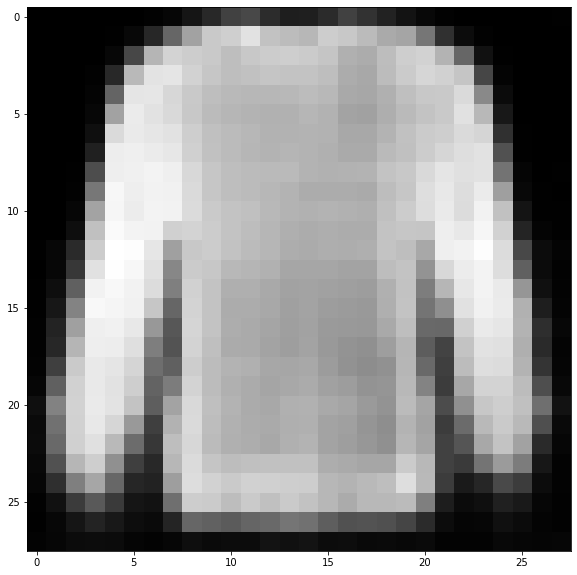

[18.52732712299104, -15.48275627613571, 0.204288371095938, -20.32338620493549, -6.661752155236135, -21.764853992079743, -7.641565825259516, -5.466972141533901, 6.401704649005087, -5.258010797931801, -11.857180568773117, -10.003954006529444, 48.20732590766945, -2.311084839335484, 25.905818128646445, 16.706228967844865, 12.23442603479057, 6.683848945207245, -18.176736284302653, 3.279535060043294, -1.1511570233339334, -37.651909296229476, 5.2076024887524, -1.4746777649600205, -1.2870776928146572, -5.456904636289606, -18.859865729782317, 24.113485691049284, 47.77816172519536, 0.2395023417492828, -11.512658929707651, -26.982667116661673, -2.8946247084777017, -0.30879163475979965, -8.230419404820108, 8.029861170463192, -1.0151167564869965, -17.680209302526585, -0.8314924547617615, -18.515424577684986, 16.04205102043845, -9.278609832404614, -1.9487623434942343, -7.882544457301824, 2.425670391597805, -0.7458533206736959, -11.510012837929498, 8.373423653835488, -7.847988078264983, -2.2994108850

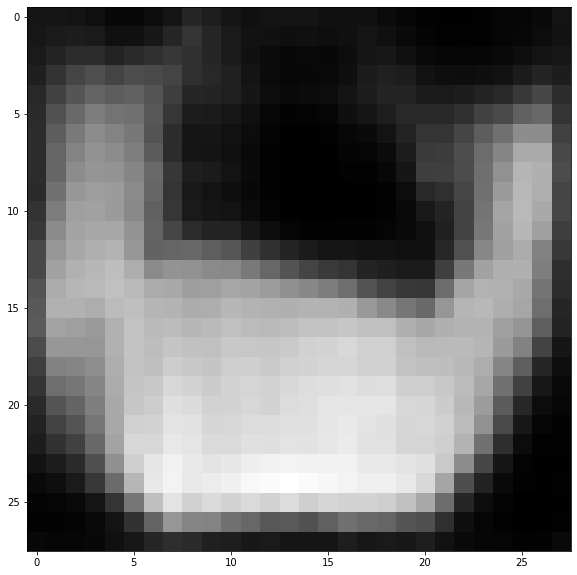

[14.665750897841477, 15.292734974155138, -4.833804512405024, 7.165354156487716, 18.23855613767634, -0.6616838320868652, -14.419144164101052, -24.018835736779206, 0.6189296278282725, -9.275931607988397, -16.684758972028668, 1.1379935158243129, 19.861932061392082, -5.1024069856156276, -25.28120025999624, 9.699569685211078, -4.07264560861902, 3.7173669225773267, 30.58965258093791, -14.341068913825248, -5.483533180778656, -21.192716591663565, 18.820555509277355, -1.8001739341146177, 6.851472154094594, -2.231783193016822, -1.2836925762483133, 11.830050565714597, 21.12939995584158, 0.2840739911553658, 5.154328340576896, 5.486654224381439, 1.9216349389581602, -0.23255540610607284, 7.373433174863671, -13.575614459098293, -0.1047189304594287, 2.7480112886095682, -20.483359048964946, 39.527763527763355, -0.7042593842216291, 17.56173999134507, -4.677585839767984, 28.169327370234832, -33.38402253663028, -14.058898980277537, 9.261648376840522, -3.151057518465336, 0.7027064019937903, -5.089339418427

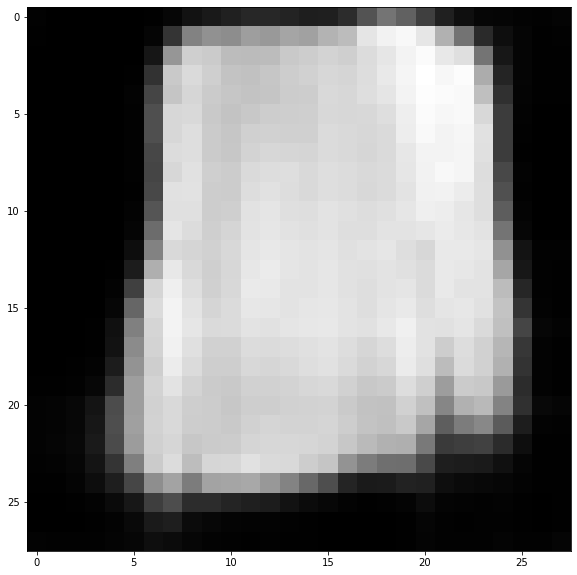

[-5.8083886772813, 21.01854997902734, -16.969810103497274, 2.0804048410567404, 6.997239587457663, 7.670344564270771, -32.119800242336545, -3.85603393762225, 14.549546372098305, -3.2739082380324085, -15.05076236346683, 11.344773495437863, 17.461578981587994, -6.521825467911076, 20.01141709874547, 13.581940910846868, 3.939415135598569, 30.15118936214158, 65.62966015146269, -22.240217509632885, -0.30532382731095353, -3.429210770575253, 16.82998991444323, 2.8049666192708074, 4.520800963427618, -11.228604959113266, -25.10041435171476, 15.974227114267535, 25.813475086753364, 0.009361949149231885, -7.332510160640563, -4.031874868577333, 3.504966171409169, -0.8692454219431305, -13.951139705137239, -13.292535934587814, -0.6419779617603734, -22.706139317754367, -8.165577953519417, 26.278976170533568, -1.9485054565294178, 3.5904551306085786, 12.071882433002067, 4.046640737625701, -9.296499853405017, -2.766168008599019, 6.304450619608435, 6.457948590185577, 11.736598576901258, -4.438770706122161, 

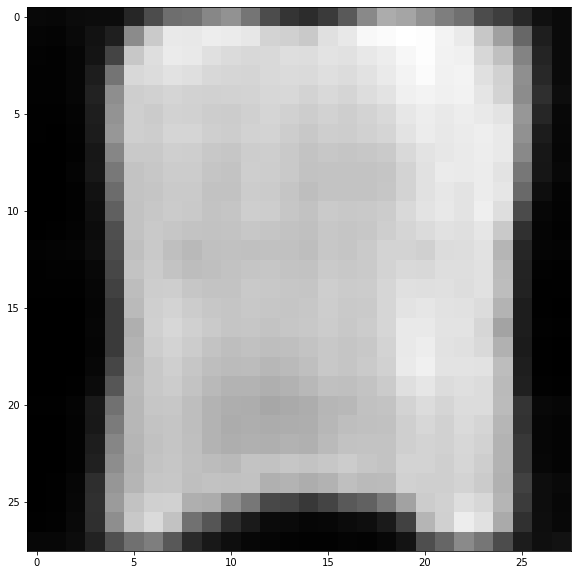

[17.79664520572021, -26.4084850703396, -8.84594599467712, -13.123780541639693, -1.2530809125090627, -20.254148386851003, -19.64784373521746, -15.337793713099154, 5.295214974679025, -6.123568636789343, -3.7475326788254506, 7.390530759318899, 32.69078092650171, 3.106240506871247, -0.0007051169940339719, -3.0112956790646557, 16.470770771745812, -23.561414586068032, 64.08405060263462, -8.061579474933996, -3.299786456266448, 8.19518509279947, -9.808836687859026, -1.9237943956174703, -9.605473775636902, -1.0463876695658847, -15.602798332627199, 19.464187864107632, 14.805530002585357, -0.06970073676502865, -17.761858269008485, 0.22377476144958308, -5.26146889525487, 13.187905013434985, -15.120015922661006, 22.510299022398534, 19.97837614533337, -10.851008991001091, 6.9210512595231535, 9.523256913701982, 2.449337167896836, 27.911301080560925, -9.27310148731177, 10.396243537089937, -33.887470029821934, 4.55817077570628, 5.551566591358554, -0.23449791749176896, 13.505833525757808, 4.446046458846

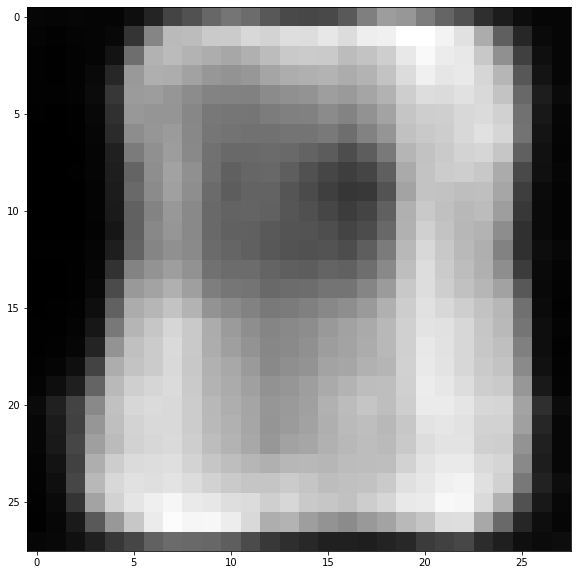

[26.767561296585228, 20.733937110815077, 9.987601906568145, 13.62109463853541, 23.421145182976034, 7.184974904201418, -5.9948743664543365, -2.2691571144734652, -8.804937879205289, 10.335259417133276, -16.144583459585093, -0.05593551188187185, 27.87606373398382, -0.331126092595742, -15.229534186441615, 13.699575172316969, 8.03528188391466, 29.693208939227326, 12.544060784768476, 4.822307081631607, -13.214011479501142, -37.35171483347627, 18.449970256007084, 10.131867587818693, 12.094506217832539, 3.165121387423614, -14.166618342129656, -0.725147130234026, 41.31785586952171, 0.2560097946853204, 3.6349514770782747, -9.00813372460139, 1.2140171540688698, 0.7161074167269312, -6.465012297468013, 24.924442379558137, 14.75596903327321, 19.45419573289086, -28.98509103896119, 21.352992149221038, -37.805016906819866, -1.1163901245862373, 6.653263764266672, -1.1601454637283908, -0.14130216594003286, 2.6664229269012765, -0.44018984193606414, 17.116987613443236, -24.132535329164646, 1.40602113647249

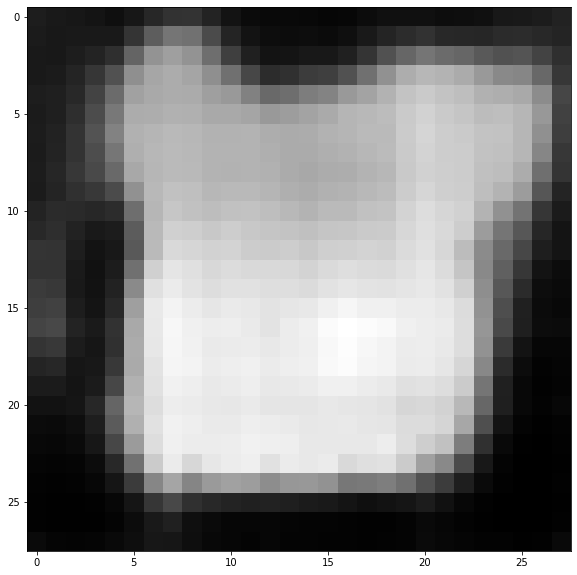

[-11.20412574954507, -3.036511705669845, -1.404564289335557, -30.613911713833303, 1.4472201343459723, -21.87081839866142, -7.300822006651348, -9.493700700327103, -9.019888852777541, -3.3047698160617305, 18.766291695810423, 14.655070746301359, 56.68234382976751, -6.736883912030704, 10.416047938678751, -5.149167155631822, 16.459039650224877, -2.4876733914566387, 67.04768452815716, 0.9659158822696341, -2.485071084621172, 15.492893721450429, -17.036952948579618, -7.84856659105273, 0.8076301373013219, -1.871890308541328, -6.520199044210209, 25.054684276528405, 28.00436164341638, -0.08820010719492552, 15.394722850008435, -21.774657583390514, 4.5349712180318775, 25.836978206533992, -9.765966827535712, -7.848433739651398, 11.529032859710998, -22.836200715987147, 17.644489434808406, 11.32060981593522, -5.094149746664563, 22.245663649005756, 16.91791693309535, 34.74092362958755, -33.22545989430094, -11.874251680540581, -4.402132267598187, 21.28994111603285, -14.704969682014415, -9.47185769057706

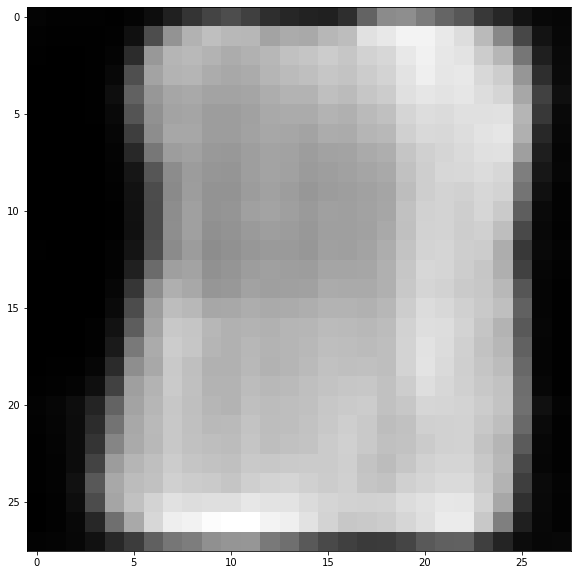

In [50]:
import numpy as np
import random
for j in range(0,10):
    random_vector = []
    for i in range(0,64):
        minimum = np.min(encoded_samples['Enc. Variable '+str(i)])
        maximum = np.max(encoded_samples['Enc. Variable '+str(i)])
        random_vector.append(random.uniform(minimum, maximum))
    print(random_vector)

    encoded_value = torch.tensor(random_vector).float().unsqueeze(0).to(device)
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()